In [60]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima     
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [61]:
df_holidays_events = pd.read_csv('holidays_events.csv')
df_oil = pd.read_csv('oil.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')
df_transactions = pd.read_csv('transactions.csv')

# DATA AUDIT

In [62]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [63]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [64]:
df_sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [65]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [66]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [67]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [68]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


# FEATURE ENGINERING

In [84]:
#Transforming date
df_train["date"]= pd.to_datetime(df_train["date"], format='%Y.%m.%d')
df_train.sort_values(by="date", ascending=True, inplace=True)

df_train['month_year'] = df_train['date'].apply(lambda x: x.strftime('%Y-%m'))
df_train['year'] = df_train['date'].apply(lambda x: x.strftime('%Y'))
df_train['month'] = df_train['date'].apply(lambda x: x.strftime('%m'))
df_train['day'] = df_train['date'].apply(lambda x: x.strftime('%d'))

#Transforming Date and Sales Data
ts = df_train.groupby('date')['sales'].sum().reset_index()

# Exploratory Data Analysis

In [69]:
#Check the stores data

In [70]:
df_stores.shape

(54, 5)

In [71]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [72]:
df_stores.state.value_counts()

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: state, dtype: int64

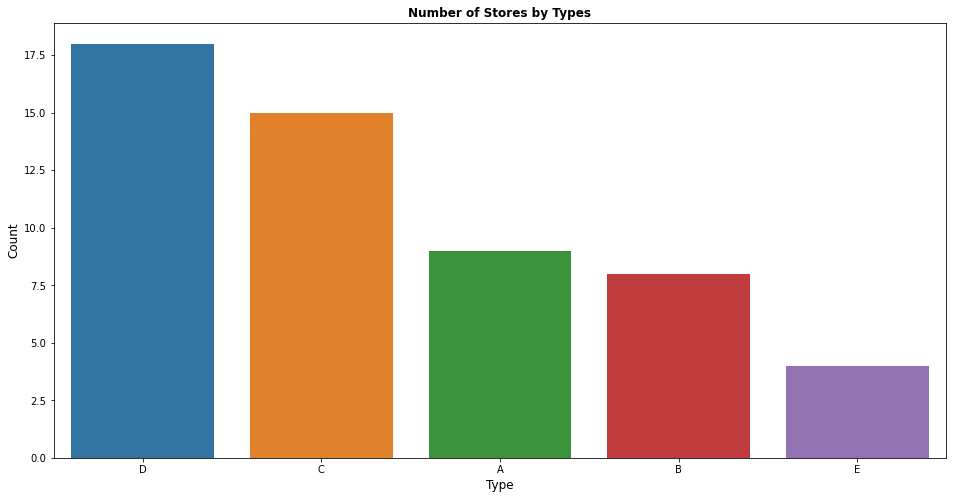

In [47]:
#Number of Stores by Types
plt.figure(figsize=(16,8))
sns.countplot(data=df_stores,x='type', order=df_stores.type.value_counts().index)
plt.title('Number of Stores by Types', fontweight="bold")
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

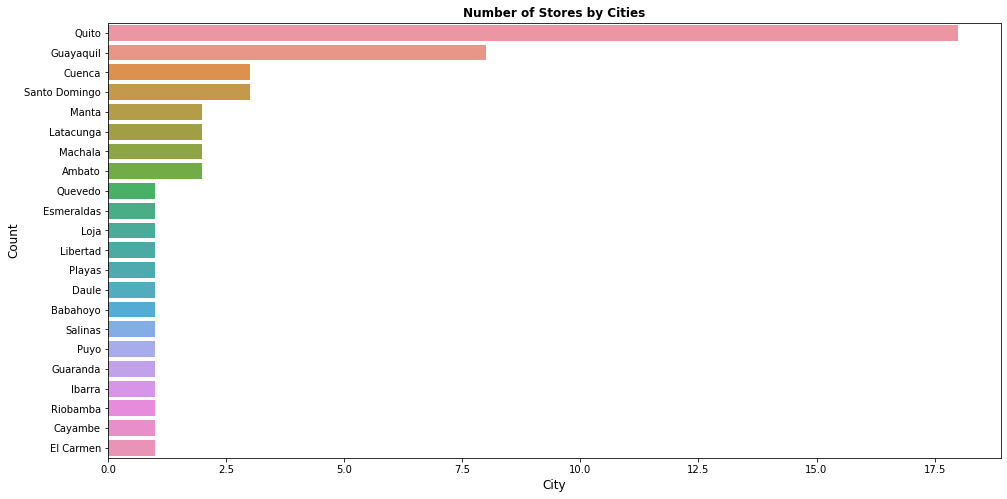

In [48]:
#Number of Stores by Cities
plt.figure(figsize=(16,8))
sns.countplot(data=df_stores,y='city', order=df_stores.city.value_counts().index)
plt.title('Number of Stores by Cities', fontweight="bold")
plt.xlabel('City', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

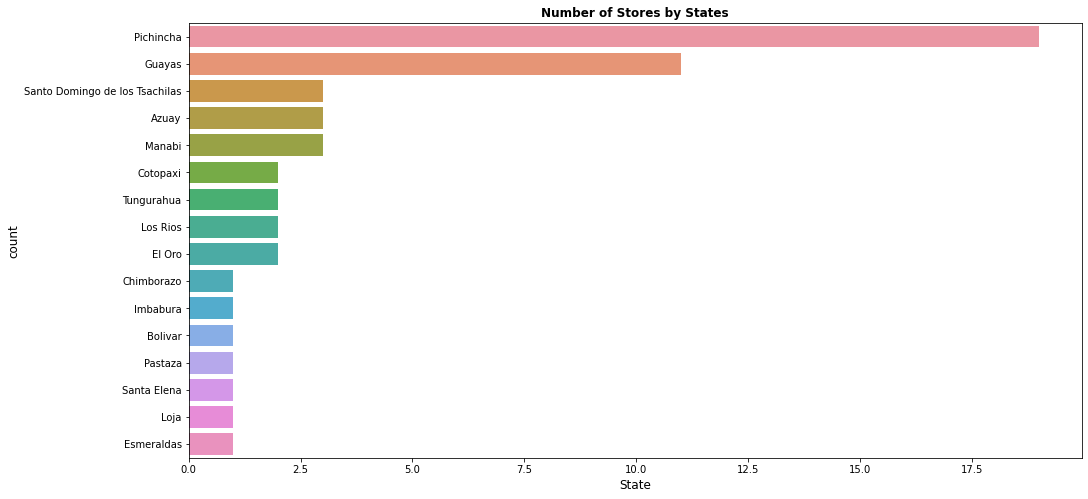

In [49]:
# Number of Stores by States
plt.figure(figsize=(16,8))
sns.countplot(data=df_stores, y='state', order=df_stores.state.value_counts().index)
plt.title('Number of Stores by States', fontweight="bold")
plt.xlabel('State', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.show()

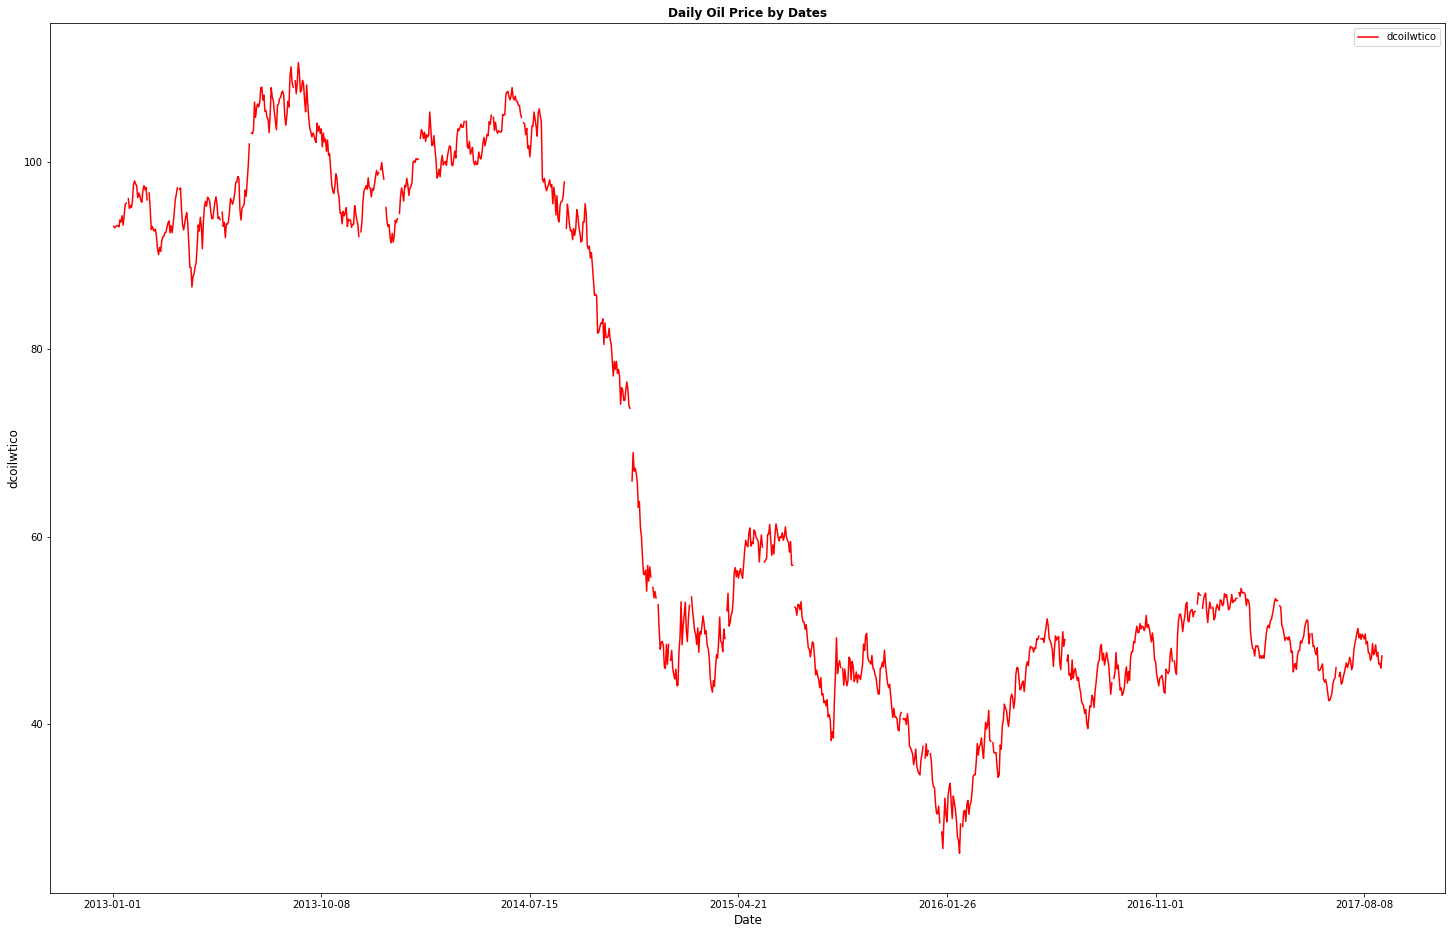

In [50]:
#Daily Oil Price by Dates
fig,axes= plt.subplots(figsize=(25,16))
df_oil.plot.line(x="date", y="dcoilwtico", color='#FF0000' , ax = axes, rot=0)
plt.title('Daily Oil Price by Dates', fontweight="bold")
plt.xlabel('Date', fontsize=12)
plt.ylabel('dcoilwtico', fontsize=12)
plt.show()

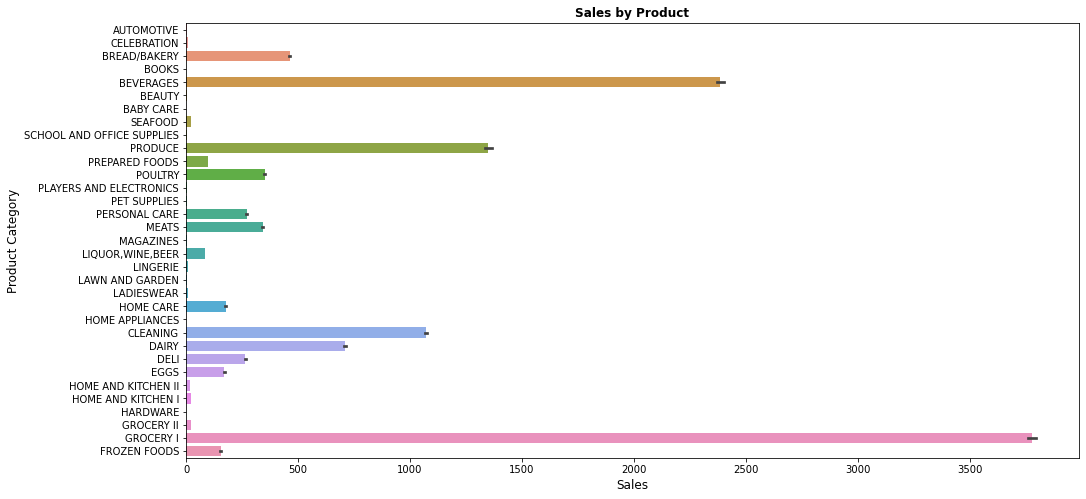

In [51]:
#Sales by Product
plt.figure(figsize=(16,8))
sns.barplot(x='sales',y='family',data=df_train)
plt.title('Sales by Product', fontweight="bold")
plt.xlabel('Sales', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.show()

In [52]:
#Merge train data and stores data
train_stores = pd.merge(df_stores,df_train,on='store_nbr')

Text(0.5, 0, 'Sales')

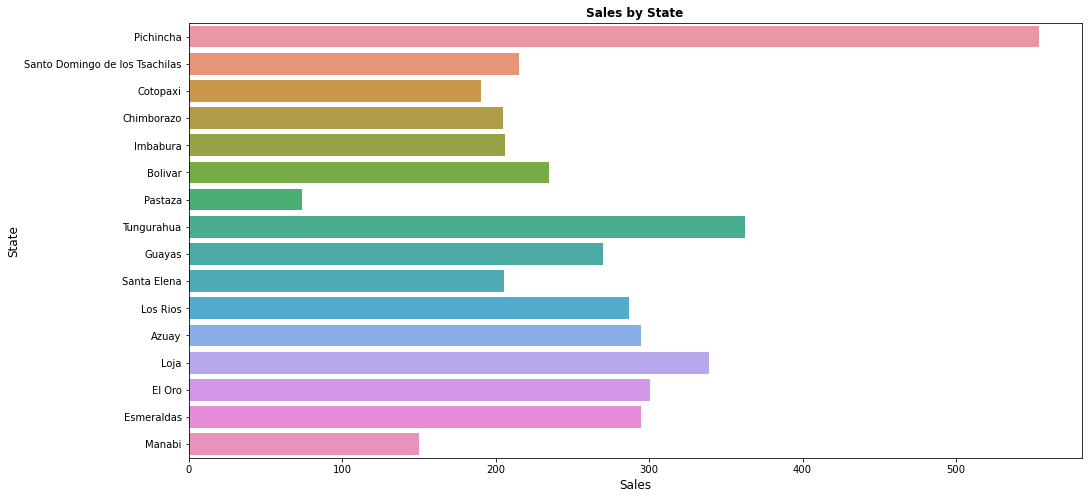

In [53]:
# Sales by States
plt.figure(figsize=(16, 8))
sns.barplot(x='sales',y='state',data=train_stores, ci=None)
plt.title('Sales by State',fontweight="bold")
plt.ylabel('State', fontsize=12)
plt.xlabel('Sales', fontsize=12)

Text(0.5, 0, 'Sales')

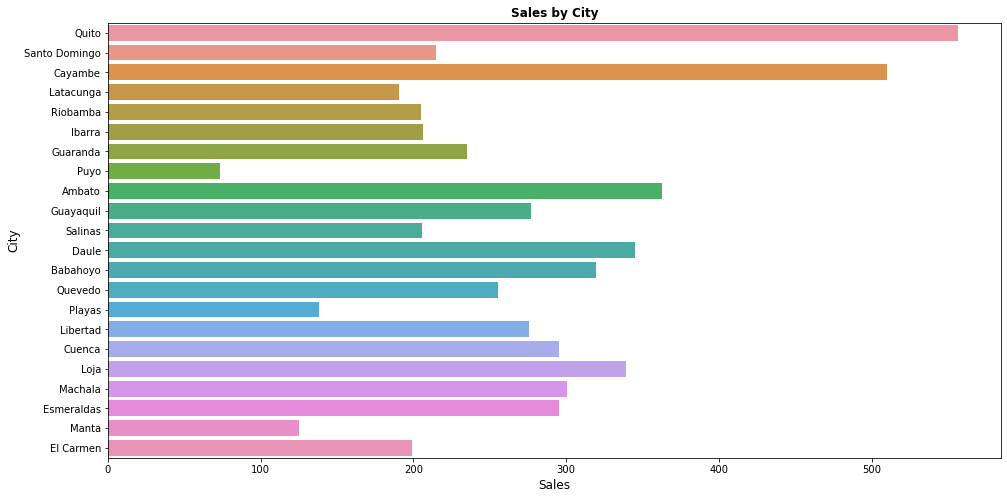

In [54]:
#Sales by City
plt.figure(figsize=(16, 8))
sns.barplot(x='sales',y='city',data=train_stores, ci=None)
plt.title('Sales by City',fontweight="bold")
plt.ylabel('City', fontsize=12)
plt.xlabel('Sales', fontsize=12)

# Forecasting Analysis

In [85]:
#Prediction total sales per month
ts= df_train.groupby('date')['sales'].sum().reset_index()
ts.set_index('date',inplace=True)
ts

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229
...,...
2017-08-11,826373.722022
2017-08-12,792630.535079
2017-08-13,865639.677471


In [87]:
y = ts['sales'].resample('MS').mean()
y['2017':]

date
2017-01-01    849295.481797
2017-02-01    830361.156248
2017-03-01    861419.925512
2017-04-01    863176.949652
2017-05-01    868124.104858
2017-06-01    856094.070833
2017-07-01    871337.985995
2017-08-01    828888.196052
Freq: MS, Name: sales, dtype: float64

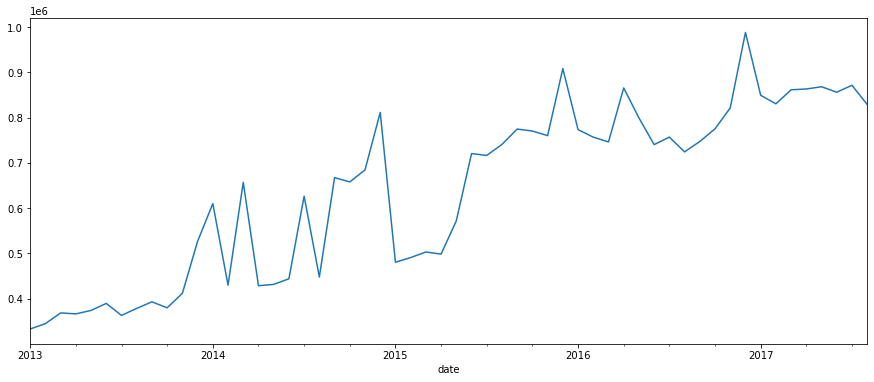

In [88]:
#Ploting the Y 
y.plot(figsize=(15, 6))
plt.show()

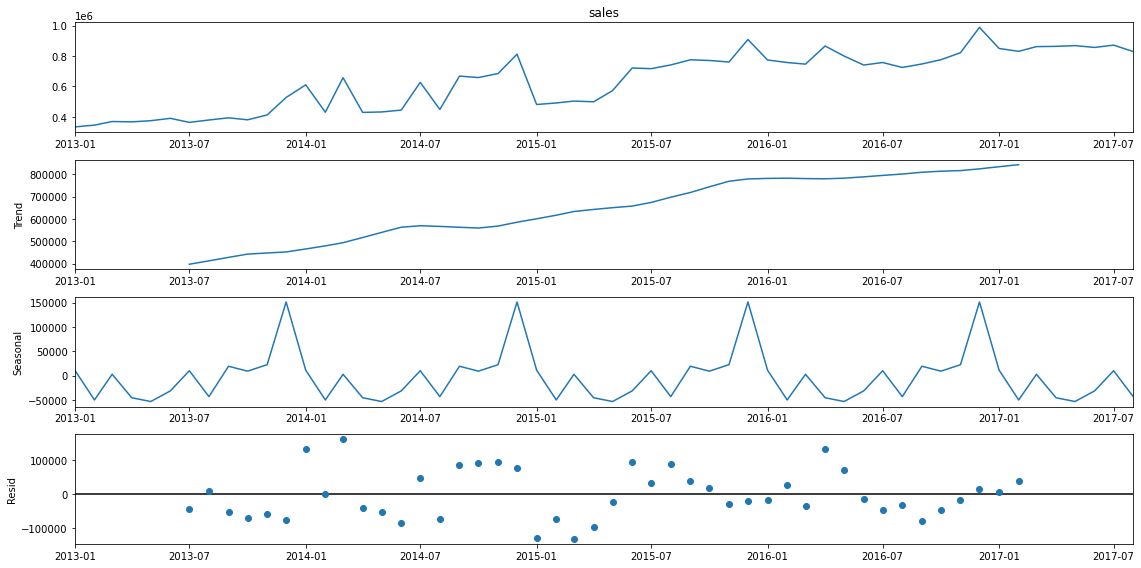

In [89]:
# Seasonal Decomposition Model
rcParams['figure.figsize'] = 16, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [90]:
#Stasionary Test (First Try)
dftest = adfuller(y.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('P-value = {:.3f}'.format(dftest[1]))
print('Critical values :')
for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

Test statistic = -1.575
P-value = 0.496
Critical values :
	1%: -3.55770911573439 - The data is not stationary with 99% confidence
	5%: -2.9167703434435808 - The data is not stationary with 95% confidence
	10%: -2.59622219478738 - The data is not stationary with 90% confidence


The result shows that the Y is not stationary in critical values (1%,5%, and 10%). So, we need to create a new variable with a lag to fix this.

In [91]:
#Creating new variable with a lag
y_lag3 = y - y.shift(3)

In [92]:
#Stasionary Test (Second Try)
dftest = adfuller(y_lag3.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('P-value = {:.3f}'.format(dftest[1]))
print('Critical values :')
for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

Test statistic = -5.182
P-value = 0.000
Critical values :
	1%: -3.5778480370438146 - The data is  stationary with 99% confidence
	5%: -2.925338105429433 - The data is  stationary with 95% confidence
	10%: -2.6007735310095064 - The data is  stationary with 90% confidence


The new variable with a lag are stationary in all critical values 1%,5%, and 10%.

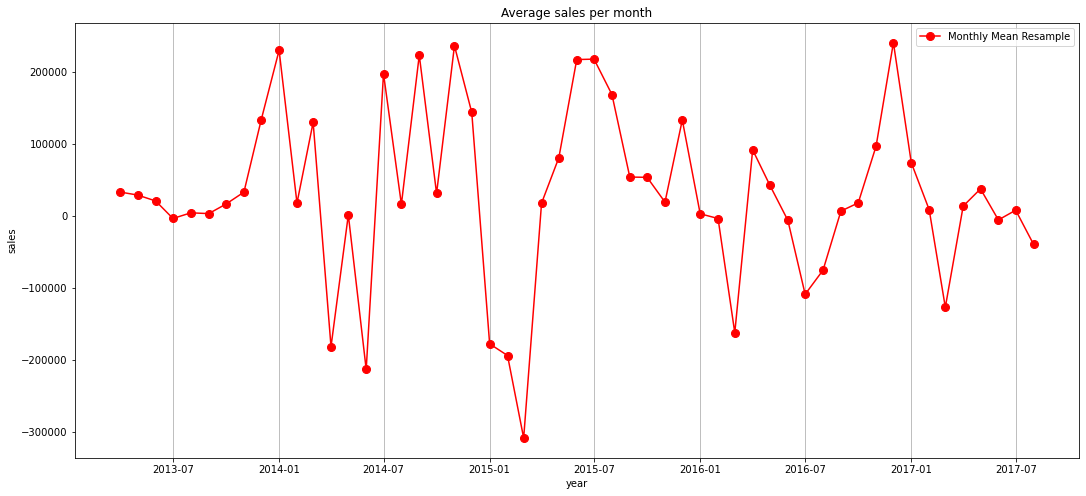

In [93]:
#Average Sales per Month
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y_lag3,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample', color='red')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('year')
ax.grid(axis='x')
ax.legend();

In [94]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [95]:
warnings.filterwarnings("ignore") 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_lag3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24357D+01    |proj g|=  4.47642D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.476D-07   1.244D+01
  F =   12.435721013718693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1394.8007535364936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  1.30951D+01    |proj g|=  1.18187D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7    136      4     3     0   4.121D+03   1.190D+01
  F =   11.895742184915468     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1336.3231247105325
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03844D+01    |proj g|=  1.14711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   4.197D-06   1.038D+01
  F =   10.384401957249695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1167.0530192119659
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.955D-06   7.633D+00
  F =   7.6325940680533000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:858.8505356219696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39460D+01    |proj g|=  3.07725D-05
  ys=-2.632E+02  -gs= 5.524E-01 BFGS update SKIPPED
  ys=-4.325E+01  -gs= 5.464E-01 BFGS update SKIPPED

At iterate    5    f=  1.17116D+01


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6    100      3     2     0   1.029D+04   1.171D+01
  F =   11.711635581711770     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1317.7031851517181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24347D+01    |proj g|=  3.96915D-01

At iterate    5    f=  1.24045D+01    |proj g|=  1.76925D-07

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45028D+01    |proj g|=  3.27418D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   3.274D-06   2.450D+01
  F =   24.502824367632343     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2750.3163291748224
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.88306D+00    |proj g|=  9.52357D-02

At iterate   15    f=  9.87998D+00    |proj g|=  8.48452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   8.914D-07   9.880D+00
  F =   9.8799769529390176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1114.55741872917
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62596D+00    |proj g|=  2.26756D-01

           * * 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2735.920160999629
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25927D+01    |proj g|=  3.85825D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.858D-07   1.259D+01
  F =   12.592664933937579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1412.3784726010088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06627D+01    |proj g|=  7.18787D-04

At iterate   10    f=  1.06489D+01    |proj g|=  3.28105D-01

At iterate   15    f=  1.05947D+01    |proj g|=  4.39262D-01

At iterate   20    f=  1.05863D+01    |proj g|=  2.57762D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     38      1     0     0   2.578D-05   1.059D+01
  F =   10.586314947051918     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1191.6672740698148
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:837.2616822455071
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.09060D+00    |proj g|=  1.49121D+00

At iterate    5    f=  7.27830D+00    |proj g|=  1.24671D-01

At iterate   10    f=  7.26879D+00    |proj g|=  1.74976D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.750D-05   7.269D+00
  F =   7.2687920539640833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x

 This problem is unconstrained.



At iterate   10    f=  9.67528D+00    |proj g|=  6.35669D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     25      1     1     0   6.357D-06   9.675D+00
  F =   9.6752829258784523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1089.6316876983867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00043D+01    |proj g|=  2.22239D-01


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     56      2     0     0   1.740D-04   9.909D+00
  F =   9.9088337920629694     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1113.7893847110527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40315D+01    |proj g|=  2.46523D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.87566D+00    |proj g|=  1.36360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   1.402D-05   6.876D+00
  F =   6.8756595038496737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:778.0738644311634
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23860D+01    |proj g|=  5.68259D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03513D+01    |proj g|=  9.40247D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.229D-07   1.035D+01
  F =   10.351294569889394     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1163.3449918276121
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.00960D+01    |proj g|=  8.23519D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   8.266D-06   1.010D+01
  F =   10.095961688175930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1138.747709075704
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34416D+00    |proj g|=  4.52434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23911D+01    |proj g|=  1.44207D-01

At iterate   10    f=  1.23837D+01    |proj g|=  5.55556D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   5.556D-06   1.238D+01
  F =   12.383698185928639     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1392.9741968240075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01114D+01    |proj g|=  8.26714D-01

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.87682D+00    |proj g|=  1.18969D-01

At iterate   10    f=  9.86908D+00    |proj g|=  3.83008D-04

At iterate   15    f=  9.86904D+00    |proj g|=  8.43616D-03

At iterate   20    f=  9.86817D+00    |proj g|=  8.06687D-02

At iterate   25    f=  9.86442D+00    |proj g|=  6.84147D-03

At iterate   30    f=  9.86434D+00    |proj g|=  1.53246D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   1.532D-06   9.864D+00
  F =   9.8643363428482917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1114.805670399

 This problem is unconstrained.



At iterate   15    f=  7.32380D+00    |proj g|=  9.86776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   4.852D-06   7.324D+00
  F =   7.3236676413270185     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:828.250775828626
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43495D+01    |proj g|=  3.31788D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01665D+01    |proj g|=  1.18269D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   3.640D-07   1.017D+01
  F =   10.166435552633827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1142.6407818949885
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.92705D+00    |proj g|=  8.23955D-02

At iterate   15    f=  9.92284D+00    |proj g|=  2.56442D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     20      1     0     0   2.564D-05   9.923D+00
  F =   9.9228438839557764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1119.358515003047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.14626D+00    |proj g|=  9.34098D-02

           * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.09117D+00    |proj g|=  5.38739D-03

At iterate   10    f=  7.09098D+00    |proj g|=  1.85825D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.858D-06   7.091D+00
  F =   7.0909772012712580     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:802.1894465423809
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26422D+01    |proj g|=  1.88309D+00

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.67070D+00    |proj g|=  8.59374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.892D-06   9.671D+00
  F =   9.6707025723415665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:1091.1186881022554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00722D+01    |proj g|=  1.05181D+00

At iterate    5    f=  9.88208D+00    |proj g|=  8.96500D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.65708D+00    |proj g|=  4.24617D-02

At iterate   15    f=  9.64154D+00    |proj g|=  5.64647D-02

At iterate   20    f=  9.64034D+00    |proj g|=  1.76630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   1.766D-05   9.640D+00
  F =   9.6403389957169914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:1089.717967520303
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  7.07003D+00    |proj g|=  1.16283D-01

At iterate   10    f=  7.06451D+00    |proj g|=  5.65237D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   5.652D-06   7.065D+00
  F =   7.0645082131331893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:799.2249198709172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89678D+00    |proj g|=  6.29528D-01

At iterate    

 This problem is unconstrained.



At iterate   10    f=  6.78585D+00    |proj g|=  9.02924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   6.157D-06   6.786D+00
  F =   6.7857669687069881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:770.0059004951827


The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 770.005. Therefore, we should consider this the optimal option out of all the models we have considered.

In [96]:
mod = sm.tsa.statespace.SARIMAX(y_lag3,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15880D+00    |proj g|=  7.28859D-01

At iterate    5    f=  7.07003D+00    |proj g|=  1.16283D-01

At iterate   10    f=  7.06451D+00    |proj g|=  5.65237D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   5.652D-06   7.065D+00
  F =   7.0645082131331893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025    

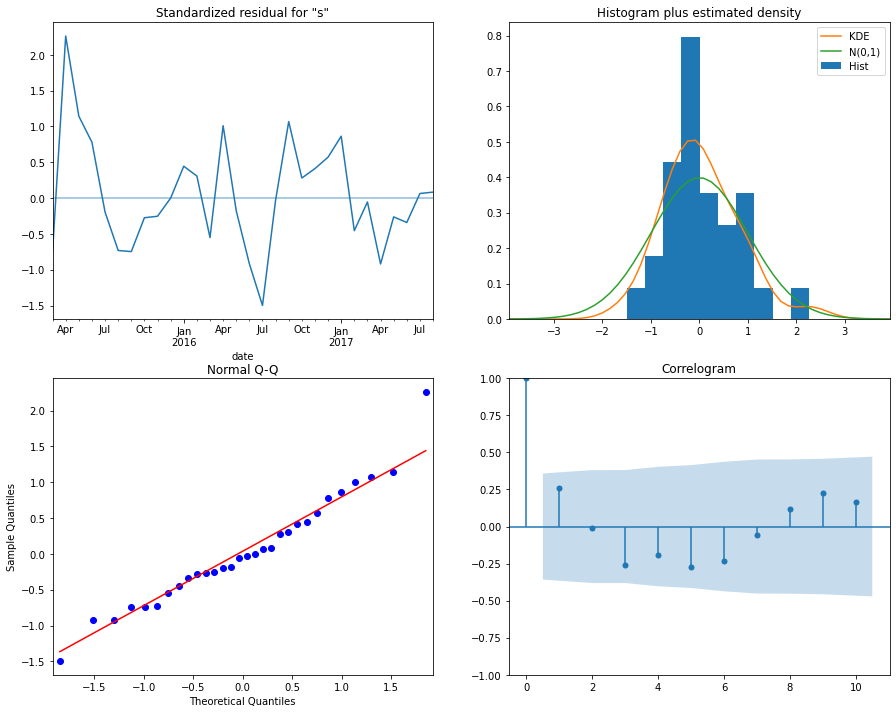

In [97]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [98]:
#Forecasting a prediction
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

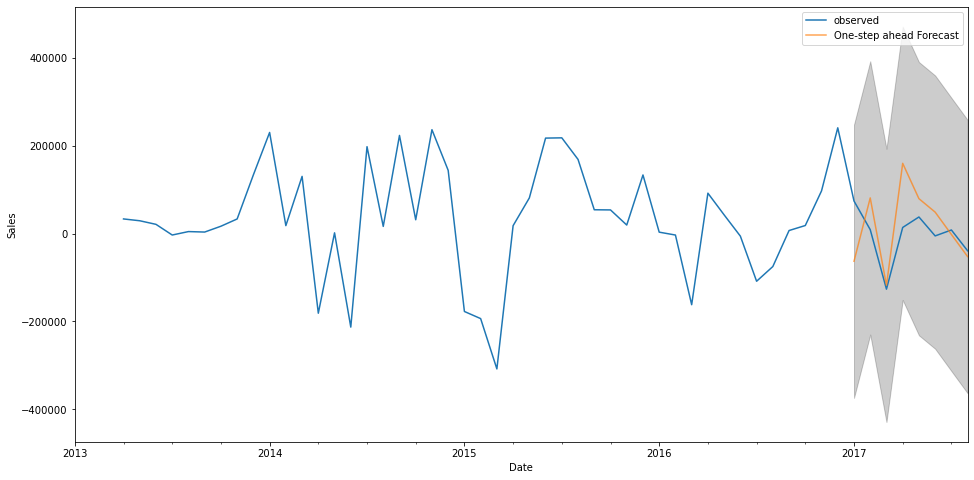

In [99]:
ax = y_lag3['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()

plt.show()

In [100]:
y_forecasted = pred.predicted_mean
y_truth = y_lag3['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6295003774.76


In [101]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))



The Root Mean Squared Error of our forecasts is 79341.06


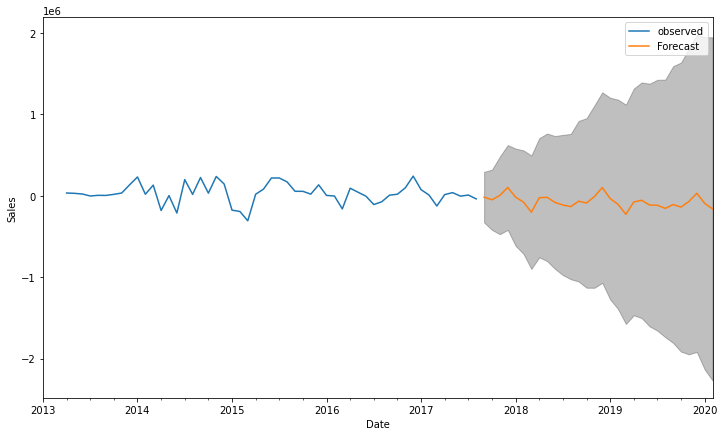

In [102]:
#Forecasting a prediction for the next 3 years
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y_lag3.plot(label='observed', figsize=(12, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()